In [60]:
import os
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from model_conv1 import ConvNet1
from mlp import MLP

DIR_PATH = os.getcwd() + '/../'

In [101]:
#model = ConvNet1(n_classes=7)
model = MLP(layers_dim=(16*16*3, 128, 3))
#model_resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False, num_classes=7)
print('MODEL INFO:', model, sep='\n')

MODEL INFO:
MLP(
  (layers): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=3, bias=True)
  )
)


In [102]:
sum_total_learnable_params = 0
for param in model.parameters():
    print(param.shape)
    sum_total_learnable_params += np.prod(np.array(param.shape))
print("Number of learnable parameters:", sum_total_learnable_params)

torch.Size([128, 768])
torch.Size([128])
torch.Size([3, 128])
torch.Size([3])
Number of learnable parameters: 98819


In [103]:
data_traj = np.load(DIR_PATH + 'data/demo_reach_object_22_07_08_18_12_37.npz', allow_pickle=True)

x = data_traj['demo_image_sequences']
y = data_traj['demo_action_sequences'][:, :3]

n_seqs = len(y)
print('Number of sequences:', n_seqs)

Number of sequences: 200


In [104]:
x = data_traj['demo_image_sequences']
y = data_traj['demo_action_sequences'][:, :3]
print(x.shape, y.shape)

(200, 16, 16, 3) (200, 3)


In [89]:
# Split

random_idx = np.random.permutation(len(x))

train_x = x[random_idx[:150]]
val_x = x[random_idx[150:]]

train_y = y[random_idx[:150]]
val_y = y[random_idx[150:]]

print(train_x.shape, val_x.shape, train_y.shape, val_y.shape)

(150, 16, 16, 3) (50, 16, 16, 3) (150, 3) (50, 3)


In [5]:
# Split

n_test_seqs = 10
n_val_seqs = 20
n_train_seqs = 140

test_x_seqs = x[: n_test_seqs]
test_y_seqs = y[: n_test_seqs]

val_x_seqs = x[n_test_seqs : n_test_seqs+n_val_seqs]
val_y_seqs = y[n_test_seqs : n_test_seqs+n_val_seqs]

train_x_seqs = x[n_test_seqs+n_val_seqs : n_test_seqs+n_val_seqs+n_train_seqs]
train_y_seqs = y[n_test_seqs+n_val_seqs : n_test_seqs+n_val_seqs+n_train_seqs]

In [6]:
data_seq = train_x_seqs, train_y_seqs, val_x_seqs, val_y_seqs, test_x_seqs, test_y_seqs
data_concat = tuple(map(np.concatenate, data_seq))
train_x, train_y, val_x, val_y, test_x, test_y = data_concat
for data in data_concat:
    print(data.shape)

(19572, 256, 256, 3)
(19572, 7)
(2521, 256, 256, 3)
(2521, 7)
(1250, 256, 256, 3)
(1250, 7)


In [7]:
for i in range(3):
    print(train_x[:,:,:,i].min(), train_x[:,:,:,i].max())

0.0 1.0
0.0 1.0
0.0 1.0


In [8]:
for i in range(7):
    print(train_y[:,i].min(), train_y[:,i].max())

-0.004583074380803431 0.004495219079719367
-0.004292269969158852 0.004255458825090781
-0.004999984723689064 0.001909017562866211
-0.012499075562036941 0.012499550914489312
-0.012468136622773249 0.012484893246380968
-0.012499669985887934 0.012496865519618974
-0.9999999962992897 -0.9999218760149191


In [80]:
'mean =', train_y.mean(axis=0), 'std =', train_y.std(axis=0)

('mean =',
 array([ 6.76969999e-04, -8.60743590e-04, -1.71629605e-03, -1.13504647e-04,
        -7.67987723e-04, -6.42218756e-03, -9.99953806e-01]),
 'std =',
 array([4.36391173e-04, 4.05277628e-04, 1.06076294e-03, 2.58872957e-03,
        2.60789325e-03, 6.08558791e-03, 3.68366965e-05]))

In [9]:
2/0.4, 1/0.025, 1/0.05

(5.0, 40.0, 20.0)

In [18]:
def normalize(x_data, y_data):
    normal_x = x_data * 5 - 1
    normal_y = y_data * np.array([40, 40, 40, 20, 20, 20, 1]).reshape(1, -1)
    return normal_x, normal_y

normal_train_x, normal_train_y = normalize(train_x, train_y)
normal_val_x, normal_val_y = normalize(val_x, val_y)
#normal_test_x, normal_test_y = normalize(test_x, test_y)

In [90]:
def normalize(x_data, y_data):
    normal_x = x_data
    normal_y = (y_data - train_y.mean(axis=0).reshape(1, -1)) / train_y.std(axis=0).reshape(1, -1)
    return normal_x, normal_y

normal_train_x, normal_train_y = normalize(train_x, train_y)
normal_val_x, normal_val_y = normalize(val_x, val_y)
#normal_test_x, normal_test_y = normalize(test_x, test_y)

In [92]:
print(normal_train_x.shape, normal_train_y.shape)

for i in range(3):
    print(normal_train_x[:,:,:,i].min(), normal_train_x[:,:,:,i].max())
    
for i in range(3):
    print(normal_train_y[:,i].min(), normal_train_y[:,i].max())

(150, 16, 16, 3) (150, 3)
0.0 1.0
0.0 0.96862745
0.0 0.9490196
-1.5169515644846767 3.515314555202332
-1.6668382799650932 2.3460567022054066
-0.7045025310290566 3.102139082234762


In [93]:
print(normal_val_x.shape, normal_val_y.shape)

for i in range(3):
    print(normal_val_x[:,:,:,i].min(), normal_val_x[:,:,:,i].max())
    
for i in range(3):
    print(normal_val_y[:,i].min(), normal_val_y[:,i].max())

(50, 16, 16, 3) (50, 3)
0.047058824 0.99607843
0.06666667 0.96862745
0.0 0.80784315
-1.007634853755161 3.4722019141720395
-1.590043051178233 2.2149884052310664
-0.6924001583647487 3.502644129492095


In [94]:
class DemoDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.x = torch.as_tensor(data_x, dtype=torch.float32).permute(0, 3, 1, 2)
        self.y = torch.as_tensor(data_y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [95]:
train_set = DemoDataset(normal_train_x, normal_train_y)
v_set = DemoDataset(normal_val_x, normal_val_y)
#test_set = DemoDataset(normal_test_x, normal_test_y)

len(train_set), len(v_set), train_set.x.shape, train_set.y.shape

(150, 50, torch.Size([150, 3, 16, 16]), torch.Size([150, 3]))

In [96]:
train_loader = DataLoader(train_set, batch_size=30, shuffle=True, drop_last=True)
v_loader = DataLoader(v_set, batch_size=100, shuffle=False)
#test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [97]:
def train(model, train_loader, v_loader, n_epochs):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    
    loss_logger = {'train':[], 'v':[]}
    
    for epoch in range(n_epochs):
        print(f"Starting epoch {epoch+1}/{n_epochs}")
        model.train()
        for batch, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model.forward(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            if batch % 100 == 0:
                print(f"batch {batch+1}/{len(train_loader)}; loss={loss.item():>6f}")
        loss_logger['train'].append(loss.item())
        print(f"Epoch {epoch+1}/{n_epochs}; loss={loss_logger['train'][-1]:>6}")
        model.eval()
        with torch.no_grad():
            v_loss = 0
            for x, y in v_loader:
                x, y = x.to(device), y.to(device)
                y_pred = model.forward(x)
                v_loss += criterion(y_pred, y).item() * len(y)
            v_loss /= len(v_loader.dataset)
            loss_logger['v'].append(v_loss)
            print(f"Epoch {epoch+1}/{n_epochs}; v_loss={loss_logger['train'][-1]:>6f}")

    return loss_logger

In [98]:
loss_log = train(model, train_loader, v_loader, n_epochs=15)

KeyboardInterrupt: 

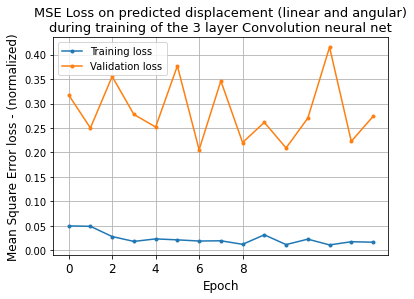

In [34]:
plt.plot(loss_log['train'], '.-', label='Training loss')
plt.plot(loss_log['v'], '.-', label='Validation loss')
plt.xticks(range(0,10, 2), fontsize=12)
plt.title("MSE Loss on predicted displacement (linear and angular)\nduring training of the 3 layer Convolution neural net", fontsize=13)
plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend()
plt.grid()

In [99]:
def train(model, train_loader, v_loader, n_epochs):
    device = torch.device('cpu')
    model.to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    
    loss_logger = {'loss':[], 'vloss':[], 'loss_class':[], 'vloss_class':[]}

    for epoch in range(n_epochs):
        print(f"Starting epoch {epoch}/{n_epochs}", end = ' ')
        model.train()
        for batch, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model.forward(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            if batch % 100 == 0:
                model.eval()
                with torch.no_grad():
                    print(f"batch {batch}/{len(train_loader)}; loss={loss.item():>6f}")
                    loss_logger['loss'].append(loss.item())
                    loss_per_class = ((y - y_pred)**2).mean(axis=0)
                    loss_logger['loss_class'].append(loss_per_class)
                    x_val, y_val = v_loader.dataset.x.to(device), v_loader.dataset.y.to(device)
                    y_pred = model.forward(x_val)
                    v_loss_per_class = ((y_val - y_pred)**2).mean(axis=0)
                    v_loss = v_loss_per_class.mean()
                    loss_logger['vloss'].append(v_loss)
                    loss_logger['vloss_class'].append(v_loss_per_class)
                    print(f"Epoch {epoch}/{n_epochs}; batch {batch}; v_loss={v_loss:>6f}")
                model.train()

    return loss_logger

In [100]:
model = MLP(layers_dim=(16*16*3, 128, 7))
loss_log = train(model, train_loader, v_loader, n_epochs=10000)

Starting epoch 0/10000 

/vol/bitbucket/hzd21/msc_project/env_pyrep/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([30, 3])) that is different to the input size (torch.Size([30, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (7) must match the size of tensor b (3) at non-singleton dimension 1

In [77]:
loss_log['vloss'] = np.array([v.item() for v in loss_log['vloss']])

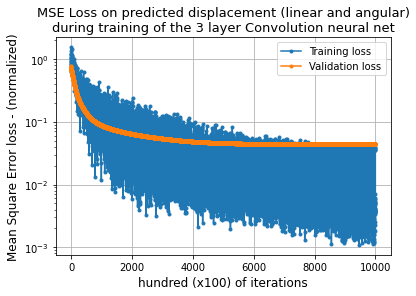

In [78]:
plt.plot(loss_log['loss'], '.-', label='Training loss')
plt.plot(loss_log['vloss'], '.-', label='Validation loss')
plt.title("MSE Loss on predicted displacement (linear and angular)\nduring training of the 3 layer Convolution neural net", fontsize=13)
plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
plt.xlabel("hundred (x100) of iterations", fontsize=12)
plt.yscale('log')
plt.legend()
plt.grid()

In [54]:
np.array([np.array([6, 7, 8]), np.array([6, 9])], dtype=object)

array([array([6, 7, 8]), array([6, 9])], dtype=object)

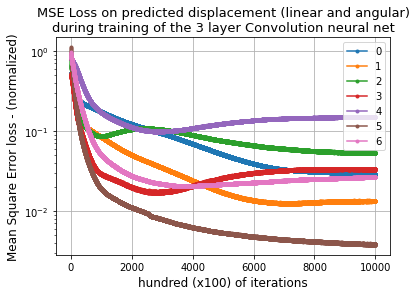

In [79]:
plt.plot(torch.stack(loss_log['vloss_class']).numpy(), '.-')
plt.yscale('log')
#plt.plot(loss_log['loss'], '.-', label='Validation loss')
plt.title("MSE Loss on predicted displacement (linear and angular)\nduring training of the 3 layer Convolution neural net", fontsize=13)
plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
plt.xlabel("hundred (x100) of iterations", fontsize=12)
plt.legend(range(7))
plt.grid()

In [49]:
torch.cat(loss_log['loss_class']).numpy()

array([0.77936435, 0.28381696, 0.90843534, 0.32577306, 0.10911089,
       0.58005923, 2.516416  , 0.4304769 , 0.15759438, 0.5594385 ,
       0.21217299, 0.05298171, 0.543753  , 1.4274449 , 0.19633065,
       0.09309821, 0.23398718, 0.14283971, 0.08069934, 0.358763  ,
       0.6636641 , 0.10399301, 0.04556169, 0.20339209, 0.11771308,
       0.05988663, 0.3675208 , 0.3252234 , 0.04138189, 0.04553068,
       0.06904925, 0.05692952, 0.03010596, 0.3368208 , 0.13355511,
       0.0531782 , 0.04816332, 0.0799436 , 0.0671792 , 0.05137894,
       0.38115495, 0.09722846, 0.03433692, 0.04851123, 0.07042106,
       0.04601322, 0.04340365, 0.32127583, 0.07001012, 0.03663394,
       0.02914176, 0.06209106, 0.03711032, 0.04560969, 0.3351309 ,
       0.07182173, 0.05039901, 0.02620028, 0.05314193, 0.04035052,
       0.05979224, 0.3462645 , 0.04889506, 0.02496699, 0.02726395,
       0.02548315, 0.03779403, 0.03736064, 0.3276405 , 0.02920969,
       0.0351723 , 0.04051785, 0.0345798 , 0.06518136, 0.03899

In [57]:
del model_mlp

In [58]:

torch.cuda.empty_cache()

In [81]:
torch.save(model.state_dict(), DIR_PATH + '/data/model_1_demo_v2.pth')

In [20]:
np.savez_compressed(DIR_PATH + '/data/loss_resnet18_5epochs', **loss_log)

/Users/hubzer/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/npyio.py:719: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  val = np.asanyarray(val)
/Users/hubzer/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


In [4]:
H = 16
K=3
S=1
P=1
D=1
H = int((H + 2*P - D*(K-1) - 1) / S + 1)
print(H)

16


In [6]:
H = 16
K=2
S=2
P=0
D=1
H = int((H + 2*P - D*(K-1) - 1) / S + 1)
print(H)

8


In [7]:
H = 8
K=3
S=1
P=1
D=1
H = int((H + 2*P - D*(K-1) - 1) / S + 1)
print(H)

8


In [8]:
H = 8
K=2
S=2
P=0
D=1
H = int((H + 2*P - D*(K-1) - 1) / S + 1)
print(H)

4


In [ ]:
H = 6
K=3
S=1
P=1
D=1
H = int((H + 2*P - D*(K-1) - 1) / S + 1)
print(H)

In [14]:
H = 4
K=4
S=1
P=0
D=1
H = int((H + 2*P - D*(K-1) - 1) / S + 1)
print(H)

1


In [11]:
H = 4
K=2
S=2
P=0
D=1
H = int((H + 2*P - D*(K-1) - 1) / S + 1)
print(H)

2


In [12]:
H = 2
K=3
S=1
P=1
D=1
H = int((H + 2*P - D*(K-1) - 1) / S + 1)
print(H)

2


In [63]:
with torch.no_grad():
    y_pred = model(test_set.x).numpy()

In [ ]:
for i in range(7):
    print(y_pred[:, i].min(), y_pred[:, i].max())

In [66]:
test_set.y.shape

torch.Size([590, 7])

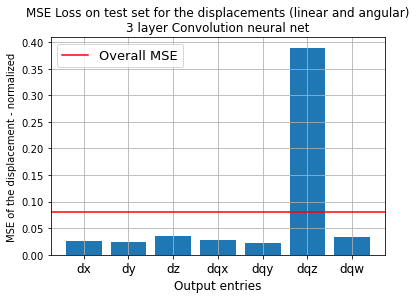

In [67]:
plt.bar(['dx', 'dy', 'dz', 'dqx', 'dqy', 'dqz', 'dqw'], ((test_set.y - y_pred)**2).mean(axis=0))
plt.xticks(fontsize=12)
plt.axhline(((test_set.y - y_pred)**2).mean(), color='r', label='Overall MSE')
plt.legend(fontsize=13)
plt.title('MSE Loss on test set for the displacements (linear and angular)\n3 layer Convolution neural net')
plt.xlabel('Output entries', fontsize=12)
plt.ylabel('MSE of the displacement - normalized')
plt.grid()

In [ ]:
plt.plot(((normal_test_y - y_pred)**2)[:100, :])
plt.legend(range(7))

In [ ]:
c = torch.nn.MSELoss()

In [ ]:
ya = torch.tensor([[0, 1], [1, 1]], dtype=torch.float32)
yb = torch.tensor([[1, 1], [1, 1]], dtype=torch.float32)
c(ya, yb)

In [ ]:
np.random.seed(123)
np.random.uniform(), np.random.randint(0,5, 10)

In [ ]:
np.random.randint(0,5)

In [ ]:
a = [1, 5, 7]

In [ ]:
a[[0, 2]]

In [ ]:
a = {0, 3, 8}

In [ ]:
a

In [ ]:
a = zip([0, 8], [7, 9])

In [ ]:
.025 / .05